<a href="https://colab.research.google.com/github/Kp-bishi/image-segmentation/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnapriyabishi","key":"a31e7e12e8a54ff0599f588ca1fed90e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kagglehub

# Download latest version
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aletbm/aerial-imagery-dataset-floodnet-challenge")

print("Path to dataset files:", path)

100%|██████████| 23.3G/23.3G [14:03<00:00, 29.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1


In [ ]:
# Mount Google Drive if needed
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install -q albumentations segmentation-models-pytorch opencv-python matplotlib
!pip install -q kaggle

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 879.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00


In [ ]:
# Categories example: update according to dataset
SEGMENTATION_CLASSES = {
    "background": 0,
    "flooded_area": 1,
    "collapsed_building": 2,
    "landslide": 3,
}
NUM_CLASSES = len(SEGMENTATION_CLASSES)

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define your dataset directory
DATA_DIR = "/root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1"

# Print DATA_DIR to confirm it's correct
print("DATA_DIR:", DATA_DIR)

# Assume a basic file structure, adapt as needed
image_paths = sorted(glob(os.path.join(DATA_DIR, "images", "*.png")))
mask_paths = sorted(glob(os.path.join(DATA_DIR, "masks", "*.png")))

# Print the number of image and mask files found
print("Number of image files found:", len(image_paths))
print("Number of mask files found:", len(mask_paths))

# ... (rest of your code) ...

DATA_DIR: /root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1
Number of image files found: 0
Number of mask files found: 0


In [ ]:
import os

DATA_DIR = "/root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1"

for root, dirs, files in os.walk(DATA_DIR):
    print(f"\n📂 Directory: {root}")
    for fname in files:
        print("  -", fname)


📂 Directory: /root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1

📂 Directory: /root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1/FloodNet Challenge - Track 1
  - class_mapping.csv

📂 Directory: /root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1/FloodNet Challenge - Track 1/Train

📂 Directory: /root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1/FloodNet Challenge - Track 1/Train/Labeled

📂 Directory: /root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1/FloodNet Challenge - Track 1/Train/Labeled/Flooded

📂 Directory: /root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1/FloodNet Challenge - Track 1/Train/Labeled/Flooded/mask
  - 7317_lab.png
  - 7488_lab.png
  - 7202_lab.png
  - 7321_lab.png
  - 9000_lab.png
  - 7266_lab.png
  - 6279_lab.png
  - 7523_

In [ ]:
import os
from glob import glob

BASE_PATH = "/root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1"

# Images from Track 2 (Train + Valid)
image_train_paths = sorted(glob(os.path.join(BASE_PATH, "FloodNet Challenge - Track 2", "Images", "Train_Image", "*.JPG")))
image_valid_paths = sorted(glob(os.path.join(BASE_PATH, "FloodNet Challenge - Track 2", "Images", "Valid_Image", "*.JPG")))

print(f"Train images found (Track 2): {len(image_train_paths)}")
print(f"Valid images found (Track 2): {len(image_valid_paths)}")

# Masks from Track 1 (Train/Labeled/Flooded/mask)
mask_paths = sorted(glob(os.path.join(BASE_PATH, "FloodNet Challenge - Track 1", "Train", "Labeled", "Flooded", "mask", "*.png")))

print(f"Masks found (Track 1): {len(mask_paths)}")

Train images found (Track 2): 1448
Valid images found (Track 2): 450
Masks found (Track 1): 51


In [ ]:
from glob import glob
import os

image_train_paths = sorted(glob(os.path.join(BASE_PATH, "FloodNet Challenge - Track 2", "Images", "Train_Image", "*.JPG")))
print("Track 2 image sample filenames:")
for p in image_train_paths[:5]:
    print(os.path.basename(p))

Track 2 image sample filenames:
10165.JPG
10166.JPG
10168.JPG
10170.JPG
10171.JPG


In [ ]:
mask_paths = sorted(glob(os.path.join(BASE_PATH, "FloodNet Challenge - Track 1", "Train", "Labeled", "Flooded", "mask", "*.png")))
print("\nTrack 1 mask sample filenames:")
for p in mask_paths[:5]:
    print(os.path.basename(p))


Track 1 mask sample filenames:
10165_lab.png
10166_lab.png
6279_lab.png
6614_lab.png
6615_lab.png


In [ ]:
import os
from glob import glob

BASE_PATH = "/root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1"

# Paths
image_train_paths = sorted(glob(os.path.join(BASE_PATH, "FloodNet Challenge - Track 2", "Images", "Train_Image", "*.JPG")))
mask_paths = sorted(glob(os.path.join(BASE_PATH, "FloodNet Challenge - Track 1", "Train", "Labeled", "Flooded", "mask", "*.png")))

# Build dict for mask lookup
mask_dict = {os.path.basename(p).replace("_lab.png", ""): p for p in mask_paths}

# Match images to masks using ID
paired_images = []
paired_masks = []

for img_path in image_train_paths:
    img_id = os.path.splitext(os.path.basename(img_path))[0]  # e.g., "10165"
    if img_id in mask_dict:
        paired_images.append(img_path)
        paired_masks.append(mask_dict[img_id])

print(f"✅ Matched image-mask pairs: {len(paired_images)}")

✅ Matched image-mask pairs: 51


In [ ]:
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define your transformations here
transform = A.Compose([
    A.Resize(256, 256), # Example resize
    A.Normalize(),      # Example normalization
    ToTensorV2()        # Convert to PyTorch tensor
])

train_dataset = FloodNetDataset(paired_images, paired_masks, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
# STEP 0: Install Dependencies
!pip install -q segmentation-models-pytorch albumentations opencv-python matplotlib

# STEP 1: Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

In [ ]:
# STEP 2: Dataset Setup (Matching Image & Mask Paths)

BASE_PATH = "/root/.cache/kagglehub/datasets/aletbm/aerial-imagery-dataset-floodnet-challenge/versions/1"

# Paths
image_train_paths = sorted(glob(os.path.join(BASE_PATH, "FloodNet Challenge - Track 2", "Images", "Train_Image", "*.JPG")))
mask_paths = sorted(glob(os.path.join(BASE_PATH, "FloodNet Challenge - Track 1", "Train", "Labeled", "Flooded", "mask", "*.png")))

# Match images to masks
mask_dict = {os.path.basename(p).replace("_lab.png", ""): p for p in mask_paths}
paired_images, paired_masks = [], []

for img_path in image_train_paths:
    img_id = os.path.splitext(os.path.basename(img_path))[0]
    if img_id in mask_dict:
        paired_images.append(img_path)
        paired_masks.append(mask_dict[img_id])

print(f"✅ Matched image-mask pairs: {len(paired_images)}")

✅ Matched image-mask pairs: 51


In [ ]:
# STEP 3: Dataset Class and Transforms

transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

class FloodNetDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].long()

        return img, mask

In [ ]:
print(f"Total matched pairs: {len(paired_images)}")

Total matched pairs: 51


In [ ]:
# Extract image IDs from filenames
image_ids = [os.path.splitext(os.path.basename(p))[0] for p in image_train_paths]
print("📸 Image IDs (first 5):", image_ids[:5])

# Extract mask IDs from filenames (stripped "_lab")
mask_ids = [os.path.basename(p).replace("_lab.png", "") for p in mask_paths]
print("🎯 Mask IDs (first 5):", mask_ids[:5])

# Print number of overlaps
common_ids = set(image_ids).intersection(set(mask_ids))
print(f"🔁 Common IDs: {len(common_ids)}")

📸 Image IDs (first 5): ['10165', '10166', '10168', '10170', '10171']
🎯 Mask IDs (first 5): ['10165', '10166', '6279', '6614', '6615']
🔁 Common IDs: 51


In [ ]:
import os

image_train_dir = os.path.join(BASE_PATH, "FloodNet Challenge - Track 2", "Images", "Train_Image")
mask_dir = os.path.join(BASE_PATH, "FloodNet Challenge - Track 1", "Train", "Labeled", "Flooded", "mask")

image_train_paths = sorted(glob(os.path.join(image_train_dir, "*.JPG")))
mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

print(f"🖼️ Found {len(image_train_paths)} training images")
print(f"🎯 Found {len(mask_paths)} masks")

🖼️ Found 1448 training images
🎯 Found 51 masks


In [ ]:
# STEP 5: Define UNet Model

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=3)
model = model.to(DEVICE)

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=3)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(256, 256, always_apply=True),  # Ensures same size
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
], is_check_shapes=False)  # 👈 Disables the shape error

<ipython-input-69-2edb864e1365>:5: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(256, 256, always_apply=True),  # Ensures same size


In [ ]:
class FloodNetDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if img.shape[:2] != mask.shape[:2]:
            print(f"[Mismatch] {os.path.basename(self.image_paths[idx])} | img: {img.shape}, mask: {mask.shape}")
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].long()

        return img, mask

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model, optimizer, criterion)
    val_loss = eval_fn(val_loader, model, criterion)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


ValueError: Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency).

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import cv2
import torch
import os

# 🔧 Step 1: Force Resize BEFORE Albumentations sees it
class FloodNetDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # ✅ Hard-resize both image and mask to same size
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].long()

        return img, mask

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [ ]:
train_dataset = FloodNetDataset(paired_images[:40], paired_masks[:40], transform=transform)
val_dataset = FloodNetDataset(paired_images[40:], paired_masks[40:], transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model, optimizer, criterion)
    val_loss = eval_fn(val_loader, model, criterion)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


IndexError: Target 5 is out of bounds.

In [ ]:
import numpy as np
unique_labels = set()

for mask_path in paired_masks:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    values = np.unique(mask)
    unique_labels.update(values)

print("🔍 Unique mask values found:", sorted(unique_labels))

🔍 Unique mask values found: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]


In [ ]:
NUM_CLASSES = max(unique_labels) + 1

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES
).to(DEVICE)

In [ ]:
class FloodNetDataset(Dataset):
    # ... (rest of your dataset class)

    def __getitem__(self, idx):
        # ... (rest of your dataset class)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].long()  # augmented is defined here

        return img, mask

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model, optimizer, criterion)
    val_loss = eval_fn(val_loader, model, criterion)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

[Epoch 1/10] Train Loss: 2.6559, Val Loss: 2.3572
[Epoch 2/10] Train Loss: 2.6475, Val Loss: 2.4611
[Epoch 3/10] Train Loss: 2.6549, Val Loss: 2.5724
[Epoch 4/10] Train Loss: 2.6612, Val Loss: 2.6145
[Epoch 5/10] Train Loss: 2.6577, Val Loss: 2.6077
[Epoch 6/10] Train Loss: 2.6606, Val Loss: 2.6280
[Epoch 7/10] Train Loss: 2.6626, Val Loss: 2.6546
[Epoch 8/10] Train Loss: 2.6481, Val Loss: 2.6437
[Epoch 9/10] Train Loss: 2.6587, Val Loss: 2.6483
[Epoch 10/10] Train Loss: 2.6519, Val Loss: 2.6100


In [ ]:
 #Data Augmentation (Rotation, Flipping, Cropping, Scaling)
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(224, 224, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
!pip install onnx # install the missing onnx package
import torch

# Dummy input (must match model input shape)
dummy_input = torch.randn(1, 3, 256, 256).to(DEVICE)

# Export the model
onnx_filename = "floodnet_unet.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_filename,
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

print(f"✅ Exported model to {onnx_filename}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 86.7 MB/s eta 0:00:00
✅ Exported model to floodnet_unet.onnx


In [ ]:
!pip install -q onnx onnxruntime

import onnxruntime as ort
import numpy as np

# Load ONNX model
ort_session = ort.InferenceSession("floodnet_unet.onnx")

# Prepare input (numpy format)
sample_input = dummy_input.cpu().numpy()

# Run inference
outputs = ort_session.run(None, {"input": sample_input})
pred = np.argmax(outputs[0], axis=1)[0]  # shape: [1, H, W] → [H, W]

print("✅ ONNX inference completed. Output shape:", pred.shape)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.2 MB/s eta 0:00:00
✅ ONNX inference completed. Output shape: (256, 256)


In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q git+https://github.com/facebookresearch/detectron2.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import torch
# Make sure detectron2 is installed
!pip install -q detectron2

# Verify CUDA availability and set device
if torch.cuda.is_available():
    DEVICE = "cuda"
    print("✅ CUDA is available. Using GPU.")
else:
    DEVICE = "cpu"
    print("⚠️ CUDA is NOT available. Using CPU. Detectron2 might run very slowly.")


⚠️ CUDA is NOT available. Using CPU. Detectron2 might run very slowly.


In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

# Setup config (using a smaller model)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))  # Smaller model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")  # Smaller model
cfg.MODEL.DEVICE = DEVICE

predictor = DefaultPredictor(cfg)

# ... (rest of your code)

model_final_9243eb.pkl: 144MB [00:04, 30.4MB/s]                           


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


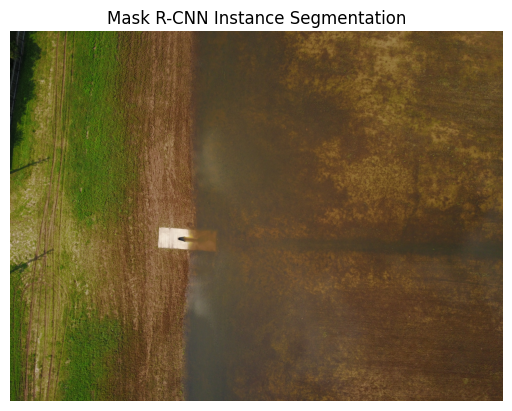

In [ ]:
# Run on a sample image
image = cv2.imread(paired_images[0])
outputs = predictor(image)

# Visualize
v = Visualizer(image[:, :, ::-1], scale=0.5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image())
plt.title("Mask R-CNN Instance Segmentation")
plt.axis('off')
plt.show()

In [ ]:
class ChangeDetectionNet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.encoder = base_model
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1)
        )

    def forward(self, img1, img2):
        f1 = self.encoder(img1)
        f2 = self.encoder(img2)
        diff = torch.abs(f1 - f2)
        out = self.decoder(diff)
        return torch.sigmoid(out)

In [ ]:
# Example: Loading a different Pix2Pix model if available
try:
    model = torch.hub.load("taesung87/pix2pix", "pix2pix", pretrained=True)
except Exception as e:
    print(f"⚠️ Error loading taesung87/pix2pix: {e}")
    print("💡 Trying an alternative model...")
    model = torch.hub.load("pytorch/vision:v0.14.0", "fcn_resnet101", pretrained=True)
    # ... (adjust code for the new model if necessary) ...

model.eval()

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


⚠️ Error loading taesung87/pix2pix: HTTP Error 404: Not Found
💡 Trying an alternative model...


Downloading: "https://github.com/pytorch/vision/zipball/v0.14.0" to /root/.cache/torch/hub/v0.14.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:07<00:00, 28.4MB/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
!pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install python-multipart

In [ ]:
# fastapi_app.py
from fastapi import FastAPI, File, UploadFile
from io import BytesIO
import uvicorn
import torch
import cv2
import numpy as np
from PIL import Image

app = FastAPI()

# Load ONNX model or PyTorch model
model.eval()

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    contents = await file.read()
    image = Image.open(BytesIO(contents)).convert("RGB")
    img = np.array(image.resize((256, 256))) / 255.0
    img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)

    with torch.no_grad():
        out = model(img)
        pred = torch.argmax(out, dim=1).cpu().squeeze().numpy()

    return {"prediction": pred.tolist()}

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class ChangeDetectionDataset(Dataset):
    def __init__(self, pre_dir, post_dir, transform=None):
        self.pre_dir = pre_dir
        self.post_dir = post_dir
        self.image_names = sorted(os.listdir(pre_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        pre_img = Image.open(os.path.join(self.pre_dir, self.image_names[idx])).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, self.image_names[idx])).convert('RGB')

        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)

        return pre_img, post_img

In [ ]:
import torch.nn as nn

class ChangeDetectionModel(nn.Module):
    def __init__(self, base_model):
        super(ChangeDetectionModel, self).__init__()
        self.base = base_model  # Use pretrained UNet or similar
        self.final_conv = nn.Conv2d(1, 1, kernel_size=1)  # Binary mask

    def forward(self, pre, post):
        diff = torch.abs(post - pre)  # Change regions
        return self.base(diff)

In [ ]:
def concat_images(pre_img, post_img):
    from PIL import Image
    return Image.new('RGB', (pre_img.width * 2, pre_img.height)).paste(pre_img, (0, 0)).paste(post_img, (pre_img.width, 0))

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
%cd pytorch-CycleGAN-and-pix2pix
!pip install -r requirements.txt

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 16.15 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
/content/pytorch-CycleGAN-and-pix2pix
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=da8015098a5a7f391b59a44dbe58814681379e83e05a77895b9bb34234af55a4
  Stored in directory: /root/.cache/pip/wheels/fa/a4/bb/2be445c295d88a74f9c0a4232f04860ca489a5c7c57eb959d9
Successfully built visdom


In [ ]:
!python train.py --dataroot /content/Project\ Data/pix2pix_flood --name flood_pix2pix --model pix2pix --direction AtoB

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/Project Data/pix2pix_flood	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
         